# Packages, Data, Functions

In [1]:
# Import packages
import numpy as np
import skimage.io as skio
import skimage.morphology as skm
from skimage import feature
from skimage.color import rgb2gray
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans
from sklearn.utils.random import sample_without_replacement
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.ndimage import gaussian_filter
from scipy.ndimage import gaussian_laplace
from scipy.ndimage import maximum_filter
from scipy.ndimage import minimum_filter
from scipy.ndimage import median_filter

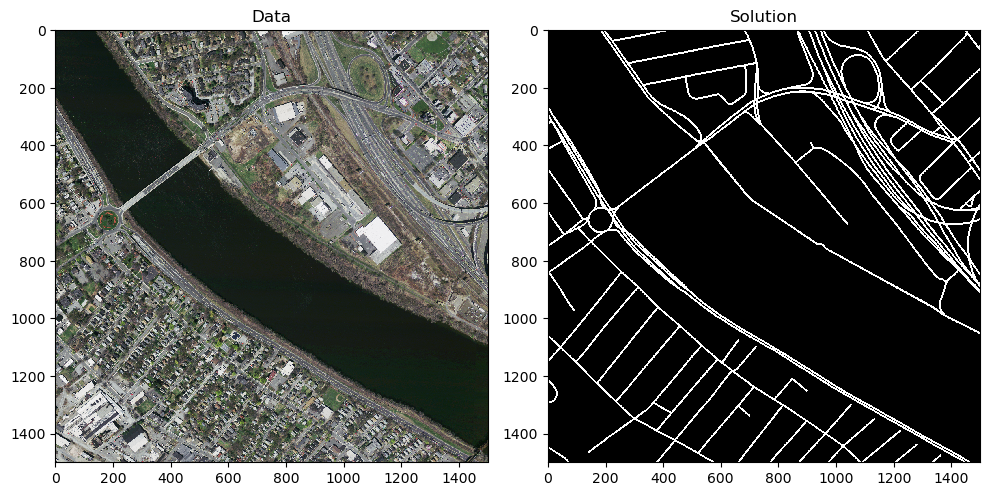

In [2]:
# Read the data
rgb = skio.imread("../../data/MA_roads/tiff/train/10828735_15.tiff")
ans = skio.imread("../../data/MA_roads/tiff/train_labels/10828735_15.tif") > 0

rgb_test = skio.imread("../../data/MA_roads/tiff/train/21929005_15.tiff")
ans_test = skio.imread("../../data/MA_roads/tiff/train_labels/21929005_15.tif") > 0

# Display training data and correct output
fig, ax = plt.subplots(1, 2, figsize = (10, 6))
skio.imshow(rgb, ax = ax[0])
ax[0].set_title("Data")
skio.imshow(ans, ax = ax[1])
ax[1].set_title("Solution");

In [3]:
# DICE
smooth=1
def dice_coef(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    return (2. * intersection + smooth) / (np.sum(y_true) + np.sum(y_pred) + smooth)
        
# Function to print several accuracy metrics
def accuracy_metrics(y_true, y_pred):
    # Create confusion matrix
    C = confusion_matrix(y_true, y_pred, labels=(True, False))

    # Overall accuracy rate
    acc = (C[0,0] + C[1,1])/C.sum()

    # Recall
    recall = (C[0,0])/(C[0,0] + C[1,0])
    
    # Precision
    prec = (C[0,0])/(C[0,0] + C[0,1])

    # DICE
    dice = dice_coef(y_true, y_pred)


    # Print results
    print("Confusion matrix:\n", C)
    print("Overall accuracy:", np.round(acc, 3), "\nPrecision:", np.round(recall, 3),
            "\nRecall", np.round(prec, 3), "\nDICE:", np.round(dice, 3)) 

# Create Training and Testing Subsets

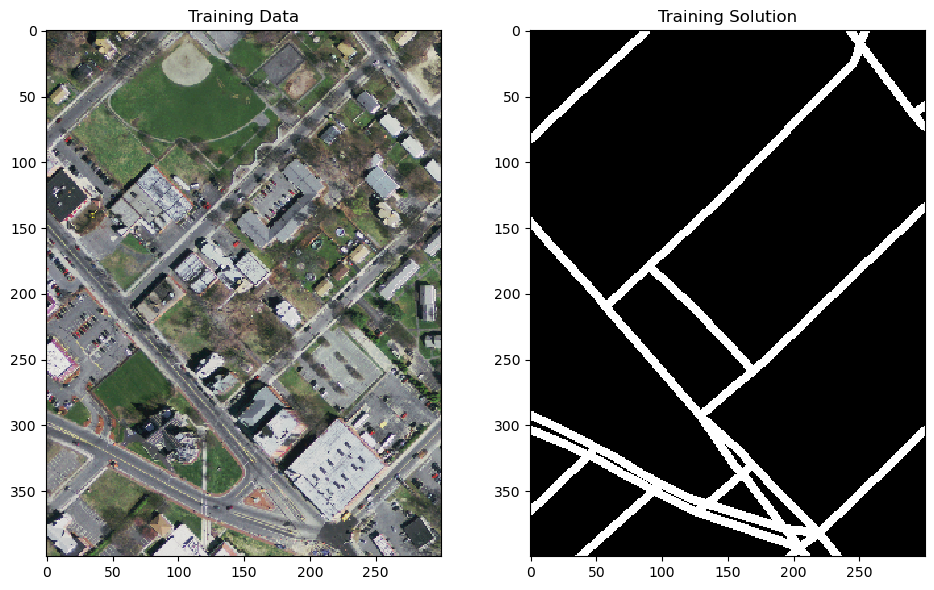

In [4]:
# Create training subset of data
# It takes too much computing power to run the model on the whole image on our own machines
small_rgb = rgb[0:400, 1200:, :]
small_ans = ans[0:400, 1200:]
# small_rgb = rgb
# small_ans = ans

fig, ax = plt.subplots(1, 2, figsize = (10, 6))
skio.imshow(small_rgb, ax = ax[0])
ax[0].set_title("Training Data")
skio.imshow(small_ans, ax = ax[1])
ax[1].set_title("Training Solution");

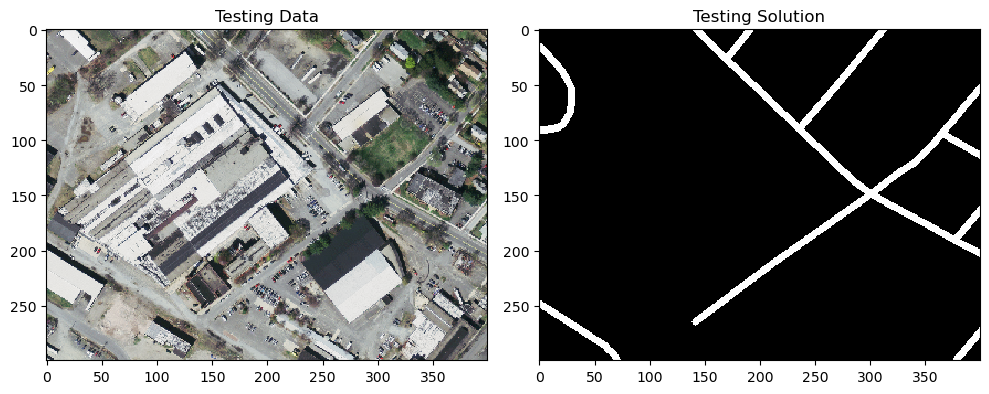

In [5]:
# Create testing subset of data
# It takes too much computing power to run the model on the whole image on our own machines
small_rgb_test = rgb[1200:, 0:400, :]
small_ans_test = ans[1200:, 0:400]
# small_rgb_test = rgb_test
# small_ans_test = ans_test

fig, ax = plt.subplots(1, 2, figsize = (10, 6))
skio.imshow(small_rgb_test, ax = ax[0])
ax[0].set_title("Testing Data")
skio.imshow(small_ans_test, ax = ax[1])
ax[1].set_title("Testing Solution");

# Random Forest Model: RGB
## Train model

In [6]:
# Flatten images
train_small_rgb = small_rgb.reshape(small_rgb.shape[0]*small_rgb.shape[1], 3)
y_train = small_ans.reshape(small_ans.shape[0]*small_ans.shape[1])

In [7]:
# Create model
RF = RandomForestClassifier()

# Fit and output the performance of the model
model1 = RF.fit(train_small_rgb, y_train)

In [8]:
# Predictions on training data
model1_pred = model1.predict(train_small_rgb)

# Confusion matrix
accuracy_metrics(y_train, model1_pred)

Confusion matrix:
 [[  8941   4082]
 [  1495 105482]]
Overall accuracy: 0.954 
Precision: 0.857 
Recall 0.687 
DICE: 0.762


While we have a really good overall accuracy rate, we are correctly predicting only 68.7% of the actual road pixels.
With a precision of 0.854, about 85.4% of our road predictions are actually roads.

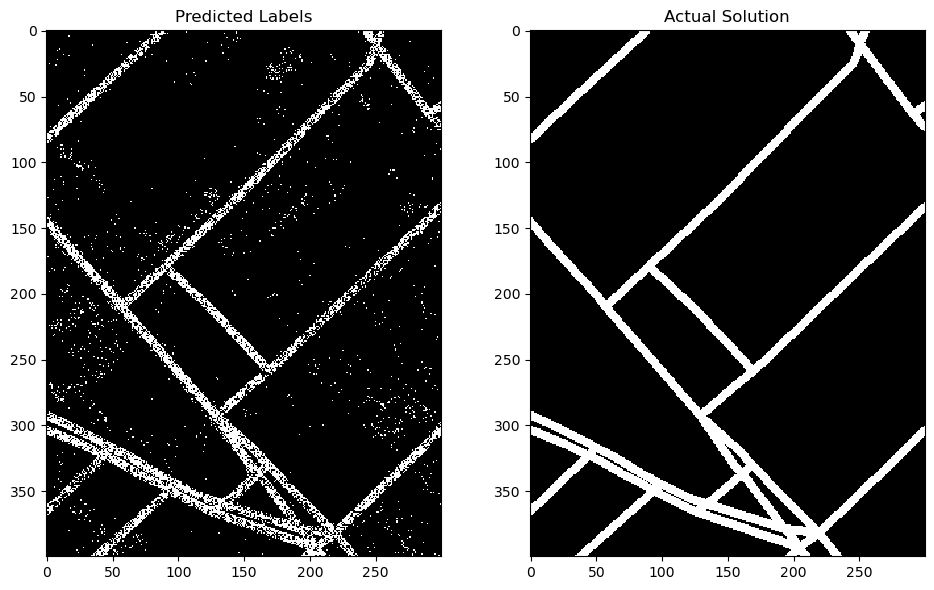

In [9]:
# Convert predictions to image
train_preds = model1_pred.reshape(small_ans.shape[0], small_ans.shape[1])

# Create figure
fig, ax = plt.subplots(1, 2, figsize = (10, 6))

skio.imshow(train_preds, ax = ax[0])
ax[0].set_title("Predicted Labels")

skio.imshow(small_ans, ax = ax[1])
ax[1].set_title("Actual Solution");

Visually, our solution looks alright, but it obviously has room for improvement.
Let's see what our results look like on the testing data.

## Test model

In [10]:
# Flatten images
test_small_rgb = small_rgb_test.reshape(small_rgb_test.shape[0]*small_rgb_test.shape[1], 3)
y_test = small_ans_test.reshape(small_ans_test.shape[0]*small_ans_test.shape[1])

In [11]:
# Predictions on testing data
model1_test_pred = model1.predict(test_small_rgb)

# Confusion matrix
accuracy_metrics(y_test, model1_test_pred)

Confusion matrix:
 [[   602   6501]
 [  4769 108128]]
Overall accuracy: 0.906 
Precision: 0.112 
Recall 0.085 
DICE: 0.097


While we still have a good overall accuracy rate, our predictions of roads is substantially worse.
We have only classified 8.3% of the road pixels correctly, and only 11.3% of our road predictions were actually roads.

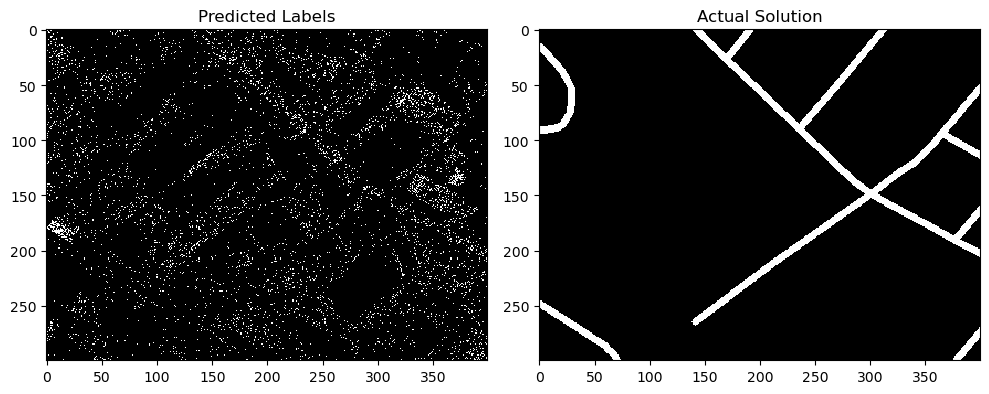

In [12]:
# Convert predictions to image
test_preds = model1_test_pred.reshape(small_ans_test.shape[0], small_ans_test.shape[1])

# Create figure
fig, ax = plt.subplots(1, 2, figsize = (10, 6))

skio.imshow(test_preds, ax = ax[0])
ax[0].set_title("Predicted Labels")

skio.imshow(small_ans_test, ax = ax[1])
ax[1].set_title("Actual Solution");

Our model did NOT generalize well! This looks terrible!

# Incorporating Additional Layers

## Create Features

In [13]:
# Create additional features

# Range of values (gray pixels will have low range)
r = small_rgb.max(axis = 2) - small_rgb.min(axis = 2)

# Canny edge detection
canny_edges_r = feature.canny(small_rgb[:,:,0], sigma=4);
canny_edges_g = feature.canny(small_rgb[:,:,1], sigma=4);
canny_edges_b = feature.canny(small_rgb[:,:,2], sigma=4);

# Gaussian blur sigma = 1
gaus_r_1 = gaussian_filter(small_rgb[:,:,0], sigma = 1)
gaus_g_1 = gaussian_filter(small_rgb[:,:,1], sigma = 1)
gaus_b_1 = gaussian_filter(small_rgb[:,:,2], sigma = 1)

# Gaussian blur sigma = 3
gaus_r_3 = gaussian_filter(small_rgb[:,:,0], sigma = 3)
gaus_g_3 = gaussian_filter(small_rgb[:,:,1], sigma = 3)
gaus_b_3 = gaussian_filter(small_rgb[:,:,2], sigma = 3)

# Gaussian blur sigma = 5
gaus_r_5 = gaussian_filter(small_rgb[:,:,0], sigma = 5)
gaus_g_5 = gaussian_filter(small_rgb[:,:,1], sigma = 5)
gaus_b_5 = gaussian_filter(small_rgb[:,:,2], sigma = 5)

# LoG blur sigma = .5
log_r_5 = gaussian_laplace(small_rgb[:,:,0], sigma = .5)
log_g_5 = gaussian_laplace(small_rgb[:,:,1], sigma = .5)
log_b_5 = gaussian_laplace(small_rgb[:,:,2], sigma = .5)

# LoG blur sigma = .6
log_r_6 = gaussian_laplace(small_rgb[:,:,0], sigma = .6)
log_g_6 = gaussian_laplace(small_rgb[:,:,1], sigma = .6)
log_b_6 = gaussian_laplace(small_rgb[:,:,2], sigma = .6)

# LoG blur sigma = .8
log_r_8 = gaussian_laplace(small_rgb[:,:,0], sigma = .8)
log_g_8 = gaussian_laplace(small_rgb[:,:,1], sigma = .8)
log_b_8 = gaussian_laplace(small_rgb[:,:,2], sigma = .8)

# Add layers to model
small_rgb_layers = np.dstack([small_rgb, r, canny_edges_r, canny_edges_g, canny_edges_b,
                             gaus_r_1, gaus_g_1, gaus_b_1, gaus_r_3, gaus_g_3, gaus_b_3,
                             gaus_r_5, gaus_g_5, gaus_b_5, log_r_5, log_g_5, log_b_5,
                             log_r_6, log_g_6, log_b_6, log_r_8, log_g_8, log_b_8])

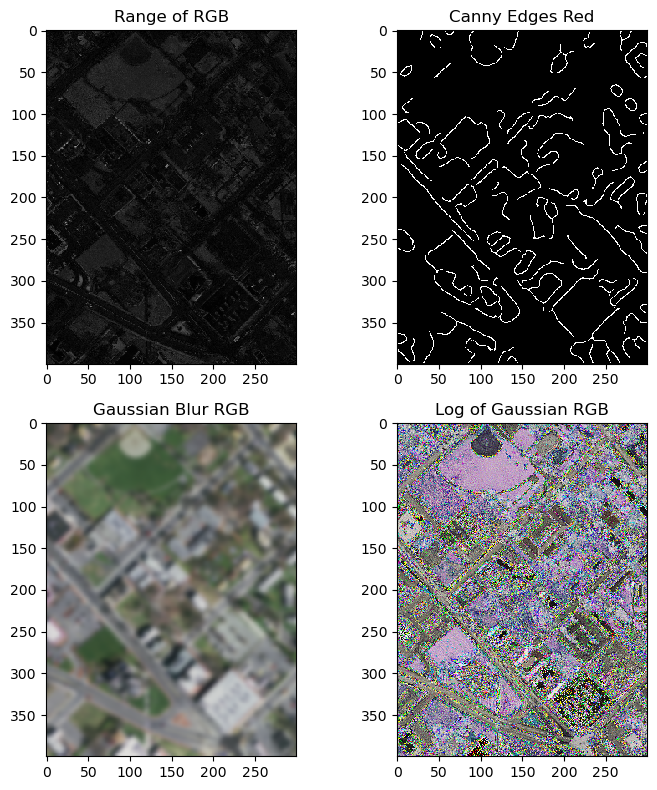

In [14]:
fig, ax = plt.subplots(2, 2, figsize = (8, 8))
skio.imshow(r, ax = ax[0,0])
ax[0,0].set_title("Range of RGB")
skio.imshow(canny_edges_r, ax = ax[0,1])
ax[0,1].set_title("Canny Edges Red")
skio.imshow(np.dstack([gaus_r_3,gaus_g_3,gaus_b_3]), ax = ax[1,0])
ax[1,0].set_title("Gaussian Blur RGB")
skio.imshow(np.dstack([log_r_5,log_g_5,log_b_5]), ax = ax[1,1])
ax[1,1].set_title("Log of Gaussian RGB");

## Train Model

In [15]:
# Train model

# Flatten image
train_small_rgb_layers = small_rgb_layers.reshape(small_rgb_layers.shape[0]*small_rgb_layers.shape[1], 25)

# Create model
RF = RandomForestClassifier()

# Fit and output the performance of the model
model2 = RF.fit(train_small_rgb_layers, y_train)

# Predictions on training data
model2_pred = model2.predict(train_small_rgb_layers)

# Confusion matrix
accuracy_metrics(y_train, model2_pred)

Confusion matrix:
 [[ 13021      2]
 [     0 106977]]
Overall accuracy: 1.0 
Precision: 1.0 
Recall 1.0 
DICE: 1.0


Before adding the additional layers to our training data, our overall accuracy was 0.954, precision was 0.854, and recall was 0.69 on our training data.
Now we have virtually perfect results!
Let's look at an image of the output.

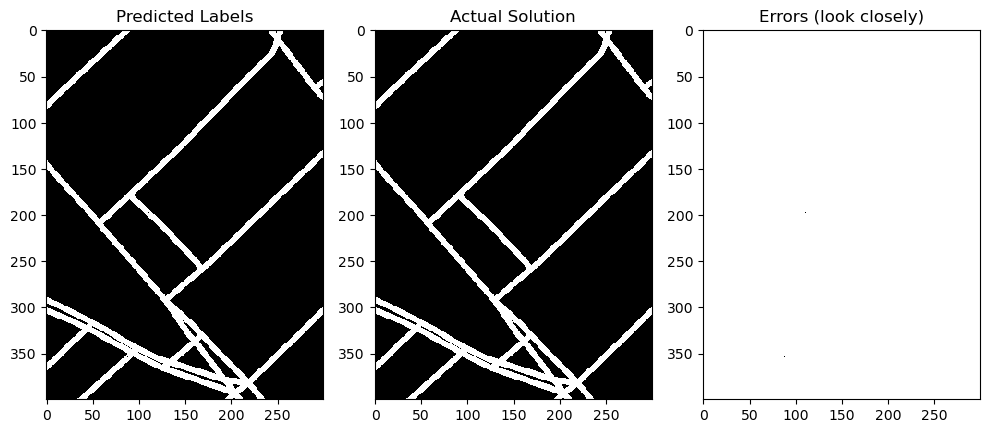

In [16]:
# Convert predictions to image
train_preds = model2_pred.reshape(small_ans.shape[0], small_ans.shape[1])

# Create figure
fig, ax = plt.subplots(1, 3, figsize = (10, 6))

skio.imshow(train_preds, ax = ax[0])
ax[0].set_title("Predicted Labels")

skio.imshow(small_ans, ax = ax[1])
ax[1].set_title("Actual Solution")

skio.imshow(train_preds==small_ans, ax = ax[2])
ax[2].set_title("Errors (look closely)");

Yep, can't even find the errors without looking closely at the difference between the two images.
Let's evaluate our results on the testing data!

## Test Model

In [17]:
# Create additional features

# Range of values (gray pixels will have low range)
rt = small_rgb_test.max(axis = 2) - small_rgb_test.min(axis = 2)

# Canny edge detection
canny_edges_rt = feature.canny(small_rgb_test[:,:,0], sigma=4);
canny_edges_gt = feature.canny(small_rgb_test[:,:,1], sigma=4);
canny_edges_bt = feature.canny(small_rgb_test[:,:,2], sigma=4);

# Gaussian blur sigma = 1
gaus_r_1t = gaussian_filter(small_rgb_test[:,:,0], sigma = 1)
gaus_g_1t = gaussian_filter(small_rgb_test[:,:,1], sigma = 1)
gaus_b_1t = gaussian_filter(small_rgb_test[:,:,2], sigma = 1)

# Gaussian blur sigma = 3
gaus_r_3t = gaussian_filter(small_rgb_test[:,:,0], sigma = 3)
gaus_g_3t = gaussian_filter(small_rgb_test[:,:,1], sigma = 3)
gaus_b_3t = gaussian_filter(small_rgb_test[:,:,2], sigma = 3)

# Gaussian blur sigma = 5
gaus_r_5t = gaussian_filter(small_rgb_test[:,:,0], sigma = 5)
gaus_g_5t = gaussian_filter(small_rgb_test[:,:,1], sigma = 5)
gaus_b_5t = gaussian_filter(small_rgb_test[:,:,2], sigma = 5)

# LoG blur sigma = .5
log_r_5t = gaussian_laplace(small_rgb_test[:,:,0], sigma = .5)
log_g_5t = gaussian_laplace(small_rgb_test[:,:,1], sigma = .5)
log_b_5t = gaussian_laplace(small_rgb_test[:,:,2], sigma = .5)

# LoG blur sigma = .6
log_r_6t = gaussian_laplace(small_rgb_test[:,:,0], sigma = .6)
log_g_6t = gaussian_laplace(small_rgb_test[:,:,1], sigma = .6)
log_b_6t = gaussian_laplace(small_rgb_test[:,:,2], sigma = .6)

# LoG blur sigma = .8
log_r_8t = gaussian_laplace(small_rgb_test[:,:,0], sigma = .8)
log_g_8t = gaussian_laplace(small_rgb_test[:,:,1], sigma = .8)
log_b_8t = gaussian_laplace(small_rgb_test[:,:,2], sigma = .8)

# Add layers to model
small_rgb_test_layers = np.dstack([small_rgb_test, rt, canny_edges_rt, canny_edges_gt, canny_edges_bt,
                             gaus_r_1t, gaus_g_1t, gaus_b_1t, gaus_r_3t, gaus_g_3t, gaus_b_3t,
                             gaus_r_5t, gaus_g_5t, gaus_b_5t, log_r_5t, log_g_5t, log_b_5t,
                             log_r_6t, log_g_6t, log_b_6t, log_r_8t, log_g_8t, log_b_8t])

In [18]:
# Flatten image
test_small_rgb_layers = small_rgb_test_layers.reshape(small_rgb_test_layers.shape[0]*small_rgb_test_layers.shape[1], 25)

# Predictions on testing data
model2_test_pred = model2.predict(test_small_rgb_layers)

# Confusion matrix
accuracy_metrics(y_test, model2_test_pred)

Confusion matrix:
 [[   336   6767]
 [  1975 110922]]
Overall accuracy: 0.927 
Precision: 0.145 
Recall 0.047 
DICE: 0.071


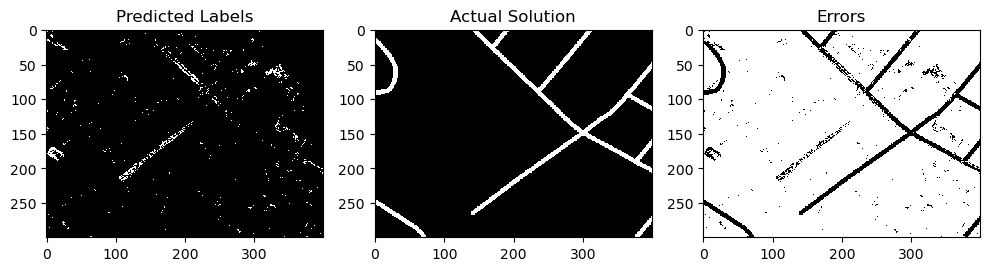

In [19]:
# Convert predictions to image
test_preds = model2_test_pred.reshape(small_ans_test.shape[0], small_ans_test.shape[1])

# Create figure
fig, ax = plt.subplots(1, 3, figsize = (10, 6))

skio.imshow(test_preds, ax = ax[0], cmap = "gray")
ax[0].set_title("Predicted Labels")

skio.imshow(small_ans_test, ax = ax[1])
ax[1].set_title("Actual Solution")

skio.imshow(test_preds==small_ans_test, ax = ax[2])
ax[2].set_title("Errors");

Adding these filters to our model had negligible impact on our results.
It improved the accuracy from 0.906 to 0.927 and the precision from 0.113 to 0.147, but the recall dropped from 0.086 to 0.047.
This means that of the pixels that actually represent roads, we are only correctly classifying 4.7% of them.
With perfect results on our training data and pitiful results on our testing data, it appears that incorporating these features in our training data led to severe overfitting!

# Sampling for Overfitting

We have fed a substantial amount of data, which ought to contain some useful information regarding roads, to our model
In our training solution, this data was in fact useful, leading to virtually 100% accuracy.
However, on the testing data for both the RGB model and the model with additional layers, our model correctly predicted less than 10% of our roads.
Perhaps this means that our model is overfit to our training data.
Since the vast majority of pixels in our training data represent non-roads, perhaps our model is overfit to the particularities of the non-road pixels in our training data.
One way to address this issue is to randomly select an equal number of pixels of both classes, and then train the model on those pixels.
Let's try randomly picking 5000 road pixels and 5000 non-road pixels for our training data and 5000 of each for our testing data and evaluating our model's performance.

## Train RGB Model

First, let's use this method on a model with just RGB layers.

In [20]:
# Flatten training images
train_rgb = rgb.reshape(rgb.shape[0]*rgb.shape[1], 3)
y_train = ans.reshape(ans.shape[0]*ans.shape[1])

# Subset training data by label
y_train_true = y_train[y_train]
y_train_false = y_train[~y_train]
train_rgb_true = train_rgb[y_train]
train_rgb_false = train_rgb[~y_train]

# Sample indices of each label
true_indices = sample_without_replacement(y_train_true.shape[0], 10000)
false_indices = sample_without_replacement(y_train_false.shape[0], 10000)

# Create modified training data
y_train_mod = np.concatenate([y_train_true[true_indices[:5000]], y_train_false[false_indices[:5000]]])
train_rgb_mod = np.concatenate([train_rgb_true[true_indices[:5000]], train_rgb_false[false_indices[:5000]]])

# Create modified testing data
y_test_mod = np.concatenate([y_train_true[true_indices[5000:]], y_train_false[false_indices[5000:]]])
test_rgb_mod = np.concatenate([train_rgb_true[true_indices[5000:]], train_rgb_false[false_indices[5000:]]])

In [21]:
# Create model
RF = RandomForestClassifier()

# Fit and output the performance of the model
model3 = RF.fit(train_rgb_mod, y_train_mod)

# Predictions on training data
model3_pred = model3.predict(train_rgb_mod)

# Confusion matrix
accuracy_metrics(y_train_mod, model3_pred)

Confusion matrix:
 [[4963   37]
 [  95 4905]]
Overall accuracy: 0.987 
Precision: 0.981 
Recall 0.993 
DICE: 0.987


While this model does not have 100% training accuracy like the additional layers model, it has improved significantly over the original RGB model.
Most notably, the training recall has improved from less than 70% to roughly 99%.
Let's see if we maintain this performance when we make predictions on our testing data.

## Test RGB Model

In [22]:
# Predictions on testing data
model3_test_pred = model3.predict(test_rgb_mod)

# Confusion matrix
accuracy_metrics(y_test_mod, model3_test_pred)

Confusion matrix:
 [[3807 1193]
 [1299 3701]]
Overall accuracy: 0.751 
Precision: 0.746 
Recall 0.761 
DICE: 0.753


Our results are encouraging!
Our overall accuracy, precision, and recall are all approximatly 0.75.
In the original RGB model, the overall accuracy was over 90%, while the precision and recall were roughly 10%.
By balancing the amount of training data in each class, we were able to balance the different accuracy metrics, improving our predictions of roads at the expense of our predictions of non-roads.
Perhaps if we incorporate our additional layers into the model, these balance improvements will translate to balanced and higher accuracy metrics. 

## Test RGB Model on New Image

While our results above are encouraging, our training and testing data were both drawn from the same image, so our model may have overtrained to this image.
Let's form predictions and compute accuracy metrics on a different image.

In [23]:
# Flatten testing images
flat_rgb_test = rgb_test.reshape(rgb_test.shape[0]*rgb_test.shape[1], 3)
y_test = ans_test.reshape(ans_test.shape[0]*ans_test.shape[1])

# Predictions on testing data
model3_test_pred_2 = model3.predict(flat_rgb_test)

# Confusion matrix
accuracy_metrics(y_test, model3_test_pred_2)

Confusion matrix:
 [[  99215   41050]
 [ 350679 1759056]]
Overall accuracy: 0.826 
Precision: 0.221 
Recall 0.707 
DICE: 0.336


Surprisingly, the overall accuracy is higher in the testing image than in the training image!
The recall is still over 70%, indicating that we are capturing most pixels representing roads correctly.
With a much lower precision, we must be predicting road pixels frequently where there are not actually roads.

Since we are working with an entire image, we can inspect our results!

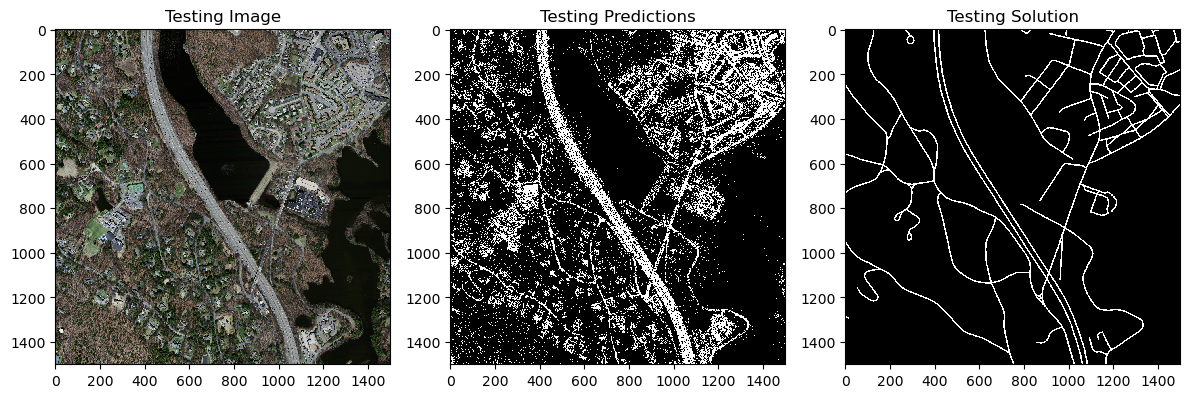

In [24]:
# Convert predictions to image
test_preds = model3_test_pred_2.reshape(rgb_test.shape[0], rgb_test.shape[1])

# Create figure
fig, ax = plt.subplots(1, 3, figsize = (12, 6))
skio.imshow(rgb_test, ax = ax[0])
ax[0].set_title("Testing Image")
skio.imshow(test_preds, ax = ax[1])
ax[1].set_title("Testing Predictions")
skio.imshow(ans_test, ax = ax[2])
ax[2].set_title("Testing Solution");

It looks like we tend to label pixels as roads when they in reality represent other human features like buildings.
We also exagerate the width of some roads

## Train Additional Layers Model

In [25]:
# Create additional features

# Range of values (gray pixels will have low range)
r_2 = rgb.max(axis = 2) - rgb.min(axis = 2)

# Canny edge detection
canny_edges_r_2 = feature.canny(rgb[:,:,0], sigma=4);
canny_edges_g_2 = feature.canny(rgb[:,:,1], sigma=4);
canny_edges_b_2 = feature.canny(rgb[:,:,2], sigma=4);

# Gaussian blur sigma = 1
gaus_r_1_2 = gaussian_filter(rgb[:,:,0], sigma = 1)
gaus_g_1_2 = gaussian_filter(rgb[:,:,1], sigma = 1)
gaus_b_1_2 = gaussian_filter(rgb[:,:,2], sigma = 1)

# Gaussian blur sigma = 3
gaus_r_3_2 = gaussian_filter(rgb[:,:,0], sigma = 3)
gaus_g_3_2 = gaussian_filter(rgb[:,:,1], sigma = 3)
gaus_b_3_2 = gaussian_filter(rgb[:,:,2], sigma = 3)

# Gaussian blur sigma = 5
gaus_r_5_2 = gaussian_filter(rgb[:,:,0], sigma = 5)
gaus_g_5_2 = gaussian_filter(rgb[:,:,1], sigma = 5)
gaus_b_5_2 = gaussian_filter(rgb[:,:,2], sigma = 5)

# LoG blur sigma = .5
log_r_5_2 = gaussian_laplace(rgb[:,:,0], sigma = .5)
log_g_5_2 = gaussian_laplace(rgb[:,:,1], sigma = .5)
log_b_5_2 = gaussian_laplace(rgb[:,:,2], sigma = .5)

# LoG blur sigma = .6
log_r_6_2 = gaussian_laplace(rgb[:,:,0], sigma = .6)
log_g_6_2 = gaussian_laplace(rgb[:,:,1], sigma = .6)
log_b_6_2 = gaussian_laplace(rgb[:,:,2], sigma = .6)

# LoG blur sigma = .8
log_r_8_2 = gaussian_laplace(rgb[:,:,0], sigma = .8)
log_g_8_2 = gaussian_laplace(rgb[:,:,1], sigma = .8)
log_b_8_2 = gaussian_laplace(rgb[:,:,2], sigma = .8)

# Add layers to model
train_rgb_mod_layers = np.dstack([rgb, r_2, canny_edges_r_2, canny_edges_g_2, canny_edges_b_2,
                             gaus_r_1_2, gaus_g_1_2, gaus_b_1_2, gaus_r_3_2, gaus_g_3_2, gaus_b_3_2,
                             gaus_r_5_2, gaus_g_5_2, gaus_b_5_2, log_r_5_2, log_g_5_2, log_b_5_2,
                             log_r_6_2, log_g_6_2, log_b_6_2, log_r_8_2, log_g_8_2, log_b_8_2])

# Flatten training image with extra layers
train_rgb_2 = train_rgb_mod_layers.reshape(train_rgb_mod_layers.shape[0]*train_rgb_mod_layers.shape[1], 25)

# Subset training data by label
train_rgb_true_2 = train_rgb_2[y_train]
train_rgb_false_2 = train_rgb_2[~y_train]

# Create modified training data
train_rgb_mod_2 = np.concatenate([train_rgb_true_2[true_indices[:5000]], train_rgb_false_2[false_indices[:5000]]])

# Create modified testing data
test_rgb_mod_2 = np.concatenate([train_rgb_true_2[true_indices[5000:]], train_rgb_false_2[false_indices[5000:]]])

In [26]:
# Create model
RF = RandomForestClassifier()

# Fit and output the performance of the model
model4 = RF.fit(train_rgb_mod_2, y_train_mod)

# Predictions on training data
model4_pred = model4.predict(train_rgb_mod_2)

# Confusion matrix
accuracy_metrics(y_train_mod, model4_pred)

Confusion matrix:
 [[5000    0]
 [   0 5000]]
Overall accuracy: 1.0 
Precision: 1.0 
Recall 1.0 
DICE: 1.0


Our training results are literally perfect.
Does this translate to our testing data?

## Test Additional Layers Model

In [27]:
# Predictions on testing data
model4_test_pred = model4.predict(test_rgb_mod_2)

# Confusion matrix
accuracy_metrics(y_test_mod, model4_test_pred)

Confusion matrix:
 [[4184  816]
 [1089 3911]]
Overall accuracy: 0.81 
Precision: 0.793 
Recall 0.837 
DICE: 0.815


It appears that there were some errors on our testing data.
Going from the RGB model to the additional layers model, our overall accuracy improved from 0.755 to 0.812, the precision improved from 0.749 to 0.796, and the recall improved from 0.767 to 0.84.
These are the most accurate road predictions yet!

While our training and testing data contained none of the same pixels, they were both drawn from the same image, so it is possible that they were overtrained to our particular image of choice.
Perhaps a more valid testing metric would involve testing our model on pixels from a different image.
Let's form predictions and compute accuracy metrics on the entirety of another image.

## Test Additional Layers Model on New Image

In [28]:
# Create additional features

# Range of values (gray pixels will have low range)
r_3 = rgb_test.max(axis = 2) - rgb_test.min(axis = 2)

# Canny edge detection
canny_edges_r_3 = feature.canny(rgb_test[:,:,0], sigma=4);
canny_edges_g_3 = feature.canny(rgb_test[:,:,1], sigma=4);
canny_edges_b_3 = feature.canny(rgb_test[:,:,2], sigma=4);

# Gaussian blur sigma = 1
gaus_r_1_3 = gaussian_filter(rgb_test[:,:,0], sigma = 1)
gaus_g_1_3 = gaussian_filter(rgb_test[:,:,1], sigma = 1)
gaus_b_1_3 = gaussian_filter(rgb_test[:,:,2], sigma = 1)

# Gaussian blur sigma = 3
gaus_r_3_3 = gaussian_filter(rgb_test[:,:,0], sigma = 3)
gaus_g_3_3 = gaussian_filter(rgb_test[:,:,1], sigma = 3)
gaus_b_3_3 = gaussian_filter(rgb_test[:,:,2], sigma = 3)

# Gaussian blur sigma = 5
gaus_r_5_3 = gaussian_filter(rgb_test[:,:,0], sigma = 5)
gaus_g_5_3 = gaussian_filter(rgb_test[:,:,1], sigma = 5)
gaus_b_5_3 = gaussian_filter(rgb_test[:,:,2], sigma = 5)

# LoG blur sigma = .5
log_r_5_3 = gaussian_laplace(rgb_test[:,:,0], sigma = .5)
log_g_5_3 = gaussian_laplace(rgb_test[:,:,1], sigma = .5)
log_b_5_3 = gaussian_laplace(rgb_test[:,:,2], sigma = .5)

# LoG blur sigma = .6
log_r_6_3 = gaussian_laplace(rgb_test[:,:,0], sigma = .6)
log_g_6_3 = gaussian_laplace(rgb_test[:,:,1], sigma = .6)
log_b_6_3 = gaussian_laplace(rgb_test[:,:,2], sigma = .6)

# LoG blur sigma = .8
log_r_8_3 = gaussian_laplace(rgb_test[:,:,0], sigma = .8)
log_g_8_3 = gaussian_laplace(rgb_test[:,:,1], sigma = .8)
log_b_8_3 = gaussian_laplace(rgb_test[:,:,2], sigma = .8)

# Add layers to model
test_rgb_layers_3 = np.dstack([rgb_test, r_3, canny_edges_r_3, canny_edges_g_3, canny_edges_b_3,
                             gaus_r_1_3, gaus_g_1_3, gaus_b_1_3, gaus_r_3_3, gaus_g_3_3, gaus_b_3_3,
                             gaus_r_5_3, gaus_g_5_3, gaus_b_5_3, log_r_5_3, log_g_5_3, log_b_5_3,
                             log_r_6_3, log_g_6_3, log_b_6_3, log_r_8_3, log_g_8_3, log_b_8_3])

# Flatten testing images
test_rgb_3 = test_rgb_layers_3.reshape(test_rgb_layers_3.shape[0]*test_rgb_layers_3.shape[1], 25)
# y_test = ans_test.reshape(ans_test.shape[0]*ans_test.shape[1])

In [29]:
# Predictions on testing data
model4_test_pred_2 = model4.predict(test_rgb_3)

# Confusion matrix
accuracy_metrics(y_test, model4_test_pred_2)

Confusion matrix:
 [[  91044   49221]
 [ 245357 1864378]]
Overall accuracy: 0.869 
Precision: 0.271 
Recall 0.649 
DICE: 0.382


Similar to the RGB model, the results on the testing image were largely similar to the results on the previous image, except for the precision dropping by over 50%
The overall accuracy is over 85%, but the recall is now 65.9% and the precision is now 26.6%.
While this is certainly not perfect, the precision and recall are still a substantial improvement over the models without sampling.
However, the recall was actually slightly higher in the sampled RGB model, indicating that the RGB model generalized better in terms of predicting road pixels.
Perhaps there are tactics we can use to combat overfitting.

Also, since we are now working with a complete image, we can once again inspect a full image illustrating our predictions versus the truth.

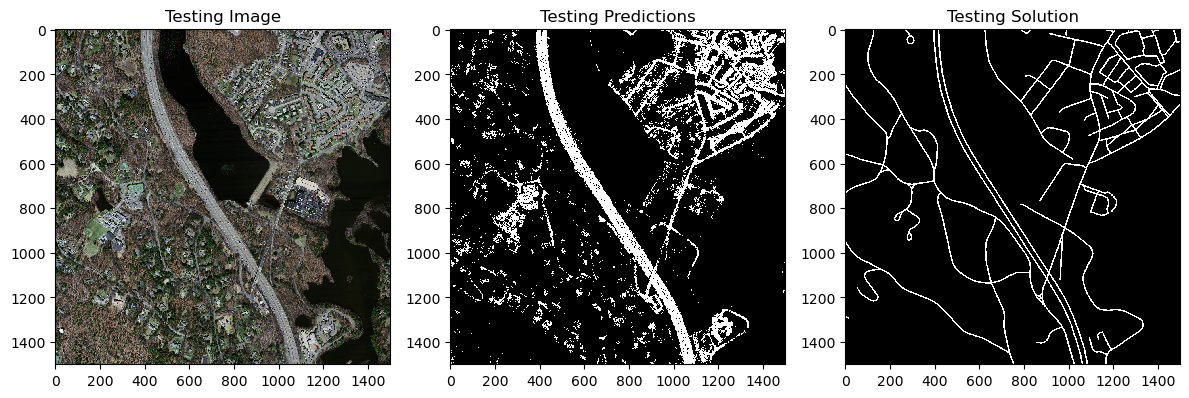

In [30]:
# Convert predictions to image
test_preds = model4_test_pred_2.reshape(test_rgb_layers_3.shape[0], test_rgb_layers_3.shape[1])

# Create figure
fig, ax = plt.subplots(1, 3, figsize = (12, 6))
skio.imshow(rgb_test, ax = ax[0])
ax[0].set_title("Testing Image")
skio.imshow(test_preds, ax = ax[1])
ax[1].set_title("Testing Predictions")
skio.imshow(ans_test, ax = ax[2])
ax[2].set_title("Testing Solution");

Once again, our model tends to incorrectly predict roads where there are other human features like buildings, and it exaggerates the width of some roads.

# PCA for Overfitting

FINISH THIS

## Train Model

In [31]:
# Add layers to model
train_pca_layers = np.dstack([rgb, r_2, # removed canny layers because they were binary
                             gaus_r_1_2, gaus_g_1_2, gaus_b_1_2, gaus_r_3_2, gaus_g_3_2, gaus_b_3_2,
                             gaus_r_5_2, gaus_g_5_2, gaus_b_5_2, log_r_5_2, log_g_5_2, log_b_5_2,
                             log_r_6_2, log_g_6_2, log_b_6_2, log_r_8_2, log_g_8_2, log_b_8_2])

# Flatten training image with extra layers
train_pca_layers_flat = train_pca_layers.reshape(train_pca_layers.shape[0]*train_pca_layers.shape[1], 22)


# Standardize the features
scaler = StandardScaler()
train_pca_layers_scaled = scaler.fit_transform(train_pca_layers_flat)

# Initialize PCA and fit the scaled data
pca = PCA(n_components=5)
layers_pca = pca.fit_transform(train_pca_layers_scaled)

In [32]:
# Subset training data by label
layers_pca_true = layers_pca[y_train]
layers_pca_false = layers_pca[~y_train]

# Create modified training data
layers_pca_mod_train = np.concatenate([layers_pca_true[true_indices[:5000]], layers_pca_false[false_indices[:5000]]])

# Create modified testing data
layers_pca_mod_test = np.concatenate([layers_pca_true[true_indices[5000:]], layers_pca_false[false_indices[5000:]]])

In [33]:
# Create model
RF = RandomForestClassifier()

# Fit and output the performance of the model
model5 = RF.fit(layers_pca_mod_train, y_train_mod)

# Predictions on training data
model5_pred = model5.predict(layers_pca_mod_train)

# Confusion matrix
accuracy_metrics(y_train_mod, model5_pred)

Confusion matrix:
 [[5000    0]
 [   0 5000]]
Overall accuracy: 1.0 
Precision: 1.0 
Recall 1.0 
DICE: 1.0


## Test Model

In [34]:
# Predictions on testing data
model5_test_pred = model5.predict(layers_pca_mod_test)

# Confusion matrix
accuracy_metrics(y_test_mod, model5_test_pred)

Confusion matrix:
 [[3972 1028]
 [1449 3551]]
Overall accuracy: 0.752 
Precision: 0.733 
Recall 0.794 
DICE: 0.762


## Test Model on New Image

In [35]:
# Add layers to model
test_pca_layers = np.dstack([rgb_test, r_3, # removed canny layers because they were binary
                             gaus_r_1_3, gaus_g_1_3, gaus_b_1_3, gaus_r_3_3, gaus_g_3_3, gaus_b_3_3,
                             gaus_r_5_3, gaus_g_5_3, gaus_b_5_3, log_r_5_3, log_g_5_3, log_b_5_3,
                             log_r_6_3, log_g_6_3, log_b_6_3, log_r_8_3, log_g_8_3, log_b_8_3])

# Flatten testing images
test_pca_layers_flat = test_pca_layers.reshape(test_pca_layers.shape[0]*test_pca_layers.shape[1], 22)

# Standardize the features
test_pca_layers_scaled = scaler.fit_transform(test_pca_layers_flat)

# Project onto principal components
layers_pca_test = pca.transform(test_pca_layers_scaled)

In [36]:
# Predictions on testing data
model5_test_pred_2 = model5.predict(layers_pca_test)

# Confusion matrix
accuracy_metrics(y_test, model5_test_pred_2)

Confusion matrix:
 [[  82227   58038]
 [ 547259 1562476]]
Overall accuracy: 0.731 
Precision: 0.131 
Recall 0.586 
DICE: 0.214


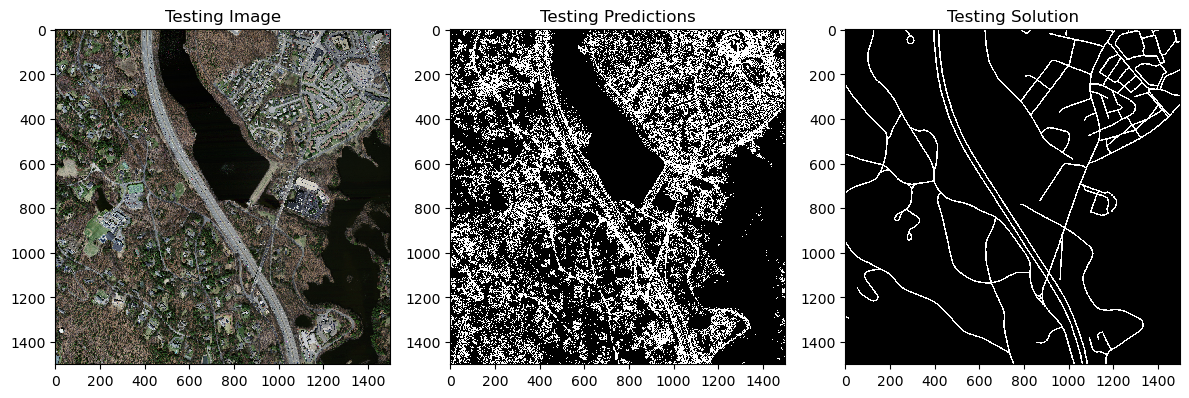

In [37]:
# Convert predictions to image
test_preds = model5_test_pred_2.reshape(test_rgb_layers_3.shape[0], test_rgb_layers_3.shape[1])

# Create figure
fig, ax = plt.subplots(1, 3, figsize = (12, 6))
skio.imshow(rgb_test, ax = ax[0])
ax[0].set_title("Testing Image")
skio.imshow(test_preds, ax = ax[1])
ax[1].set_title("Testing Predictions")
skio.imshow(ans_test, ax = ax[2])
ax[2].set_title("Testing Solution");

# Potential Future Work...

- apply pca for overfitting
- create training data by sampling multiple images
- bring in or create a DEM
- additional layers
   - try min, max, median filters?
   - try hough image?
   - Aiden's graymask?
   - something measuring the variation within a kernel
- morphology post rf?

In [38]:
# train_gray = rgb2gray(small_rgb)
# skio.imshow(train_gray)

# disk = skm.disk(3)
# disk4 = skm.disk(4)

# img_med = median_filter(train_gray, footprint = disk4)
# img_max = maximum_filter(img_med, footprint = disk)

# fig, ax = plt.subplots(1, 3, figsize = (12, 6))
# skio.imshow(img_max, ax = ax[0])
# skio.imshow(img_med, ax = ax[1])